In [189]:
from pathlib import Path

import rasterio
from rasterio.windows import from_bounds
from rasterio.env import Env

import planetary_computer
import rioxarray

import numpy as np

import matplotlib.pyplot as plt

### Define functions

In [108]:
def get_patch_size_divisible_bounds(affine_transform, original_bounds, patch_size):
    """
    Args:
        affine_transform (affine.Affine)
        original_bounds (tuple)
        patch_size (int)
    
    Returns:
        adjusted_bounds (tuple)
    """
    res_x = affine_transform.a        # pixel size width (e.g., 10.0 m for Sentinel-2)
    res_y = -affine_transform.e       # pixel seize height (make it positive)

    # Calculate desired pixel size of the crop
    width_m = bounds[2] - bounds[0]
    height_m = bounds[3] - bounds[1]

    width_px = int(width_m // res_x)
    height_px = int(height_m // res_y)

    # Adjust to the largest multiple of patch_size
    width_px_adj = (width_px // patch_size) * patch_size
    height_px_adj = (height_px // patch_size) * patch_size

    # Compute adjusted physical width/height
    adj_width_m = width_px_adj * res_x
    adj_height_m = height_px_adj * res_y

    # Adjust right and top to reduce the area (keep origin fixed at bottom-left)
    left, bottom = bounds[0], bounds[1]
    right = left + adj_width_m
    top = bottom + adj_height_m
    
    adjusted_bounds = (left, bottom, right, top)
    
    return adjusted_bounds

In [109]:
from shapely.ops import transform
from pyproj import Transformer, CRS

def crs_transformer(geometry, target_crs):
    """
    geometry (shapely.geometry.collection.GeometryCollection)
    target_crs (int)
    """
    # Define source and target CRS
    src_crs = CRS.from_epsg(4326) # WGS84
    target_crs = CRS.from_epsg(target_crs) # Actual CRS of the product

    # Create a transformer
    transformer = Transformer.from_crs(src_crs, target_crs, always_xy=True)

    # Apply transformation
    reprojected_geometry = transform(transformer.transform, geometry)

    return reprojected_geometry

In [161]:
from urllib.parse import urlparse, urlunparse

def clean_signed_url(url: str = ""):
    """
    Delete the signature token that is concatenated to the URL.
    
    Args:
        url (str)
    
    Returns:
        cleaned_url (str)
    """
    parsed = urlparse(url)
    cleaned_url = urlunparse(parsed._replace(query='', fragment=''))  # Removes query and fragment
    
    return cleaned_url

# Example usage:
s = 'https:/sentinel2l2a01.blob.core.windows.net/sentinel2-l2/30/S/VG/2025/04/02/S2B_MSIL2A_20250402T105619_N0511_R094_T30SVG_20250402T150540.SAFE/GRANULE/L2A_T30SVG_A042162_20250402T110516/IMG_DATA/R10m/T30SVG_20250402T105619_B02_10m.tif?st=2025-05-07T09%3A09%3A25Z&se=2025-05-08T09%3A54%3A25Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-05-08T04%3A11%3A30Z&ske=2025-05-15T04%3A11%3A30Z&sks=b&skv=2024-05-04&sig=WKqiUYZEG1K1TkBsQHmkOW5q%2Bt/OvuoQZJd%2BWT%2BCLio%3D'
clean_signed_url(url)

'https:///sentinel2l2a01.blob.core.windows.net/sentinel2-l2/30/S/VG/2025/04/02/S2B_MSIL2A_20250402T105619_N0511_R094_T30SVG_20250402T150540.SAFE/GRANULE/L2A_T30SVG_A042162_20250402T110516/IMG_DATA/R10m/T30SVG_20250402T105619_B02_10m.tif'

In [160]:
import re

def replace_band_with_rgbn(filename: str = "") -> str:
    """
    Replace Sentinel-2 band identifier (e.g., _B02_) in a filename with _RGBN_.

    Args:
        filename (str): The input filename containing a band code. 
                        Example: 'T30SVG_20250402T105619_B02_10m'.

    Returns:
        str: The filename with the band code replaced by 'RGBN'.
             Example: 'T30SVG_20250402T105619_RGBN_10m'.
    """
    return re.sub(r'_B\d{2}_', '_RGBN_', filename)

# Example usage:
s = "T30SVG_20250402T105619_B02_10m"
replace_band_with_rgbn(s)

'T30SVG_20250402T105619_RGBN_10m'

### Case 1. Subset GeoTIFF given a bounding box

In [53]:
url = Path("https://eks-1-hub.s3.eu-central-1.amazonaws.com/data/data_ard/SENTINEL-2/S2MSI2A/S2B_MSIL2A_20240802T090559_N0511_R050_T34SGF_20240802T103527.SAFE/T34SGF_20240802T090559_B02_10m.tif")
bounds = (528242, 4051961.0, 542624.6681694408, 4071649.0)

with rasterio.Env(AWS_NO_SIGN_REQUEST='YES'):
    with rasterio.open(url) as src:
        window = from_bounds(*bounds, transform=src.transform)
        window_affine = src.window_transform(window)
        
        # Update metadata for the cropped output
        profile = src.profile.copy()
        # Here you update the things that change after the subset. These are the affine matrix and the heigh/width of the subset
        profile.update({
            "height": int(window.height),
            "width": int(window.width),
            "transform": window_affine
        })

        # Read the defined window
        data = src.read(1, window=window)  # You can loop over bands or read multiple if you want
    
        # Write as a new GeoTIFF subset
        # Insert suffix before the file extension
        new_filename = url.stem + "_subset" + url.suffix # Append suffix to filename
        output_tif = Path('/home/data')/url.parent.name/new_filename # create full path to save
        output_tif.parent.mkdir(parents=True, exist_ok=True)
        with rasterio.open(output_tif, "w", **profile) as dst:
            dst.write(data, 1)

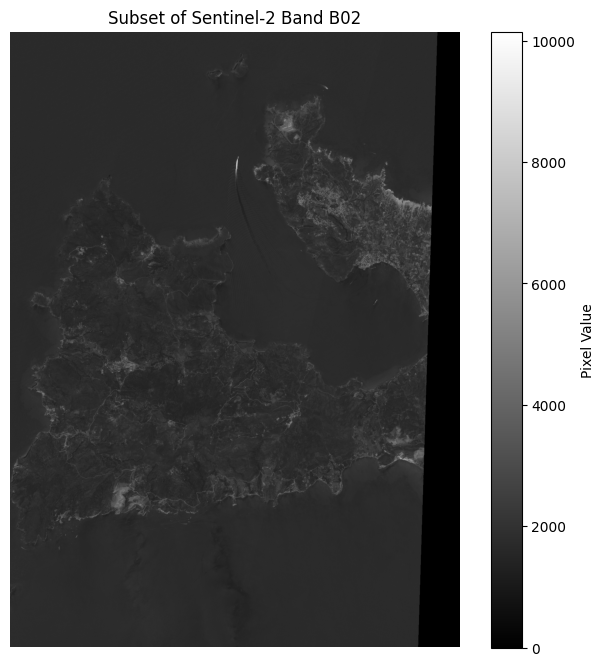

In [37]:
plt.figure(figsize=(8, 8))
plt.imshow(data, cmap='gray')  # Use 'viridis' or other colormaps for variety
plt.colorbar(label='Pixel Value')
plt.title("Subset of Sentinel-2 Band B02")
plt.axis('off')
plt.show()

### Case 2. Subset GeoTIFF with an adjusted bounding box based on the patch size of a the U-Net

In [ ]:
url = Path("https://eks-1-hub.s3.eu-central-1.amazonaws.com/data/data_ard/SENTINEL-2/S2MSI2A/S2B_MSIL2A_20240802T090559_N0511_R050_T34SGF_20240802T103527.SAFE/T34SGF_20240802T090559_B02_10m.tif")
bounds = (528242, 4051961.0, 542624.6681694408, 4071649.0)

In [14]:
patch_size = 96  # Patch size in pixels

with rasterio.Env(AWS_NO_SIGN_REQUEST='YES'):
    with rasterio.open(url) as src:

        affine_transform = src.transform  # Affine transformation

        # Get adjusted bounds
        adjusted_bounds = get_patch_size_divisible_bounds(affine_transform, bounds, patch_size)
        
        # Use adjusted bounds to extract cleanly patchable image
        window = from_bounds(*adjusted_bounds, transform=affine_transform)
        window_affine = src.window_transform(window)
        
        # Update metadata for the cropped output
        profile = src.profile.copy()
        # Here you update the things that change after the subset. These are the affine matrix and the heigh/width of the subset
        profile.update({
            "height": int(window.height),
            "width": int(window.width),
            "transform": window_affine
        })
        
        data = src.read(1, window=window)

        # Write as a new GeoTIFF subset
        # Insert suffix before the file extension
        new_filename = url.stem + "_subset_adjustedbounds2" + url.suffix # Append suffix to filename
        output_tif = Path('/home/data')/url.parent.name/new_filename # create full path to save
        output_tif.parent.mkdir(parents=True, exist_ok=True)
        with rasterio.open(output_tif, "w", **profile) as dst:
            dst.write(data, 1)
            
        print("Adjusted bounds:", adjusted_bounds)
        print("Data shape:", data.shape)  # Should be divisible by patch_size

Adjusted bounds: (528242, 4051961.0, 541682.0, 4071161.0)
Data shape: (1920, 1344)


### Case 3. Retrieve bounding boxes of COG images from Planet Computer and subset

In [115]:
from eodag import EODataAccessGateway, setup_logging

setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG
dag = EODataAccessGateway()

In the code block below you can set the parameters you desire. You can set the `geometry`, and `start` / `end` dates.

In [116]:
geometry = "MULTIPOLYGON (((-3.742157 37.221198, -3.742157 37.221198, -3.740784 37.221198, -3.740784 37.221198, -3.742157 37.221198)), ((-3.736663 37.110667, -3.736663 37.239786, -3.503148 37.239786, -3.503148 37.110667, -3.736663 37.110667)))"
search_results = dag.search(
    provider="planetary_computer",
    productType="S2_MSI_L2A",
    geom=geometry,
    start="2025-04-01",
    end="2025-04-07",
)

In [117]:
search_results

SearchResult([EOProduct(id=S2B_MSIL2A_20250402T105619_R094_T30SVG_20250402T150540, provider=planetary_computer)])

In the code block below you can change the `bands`, but be carefull because the bands that have different resolution cannot be stacked, which means that the code only works for same resolution bands.  
In case more than one products are discovered, you can also change the `product_idx`. If just one products is discovered, you can leave it as is (i.e., `0`).

In [119]:
bands = ['B02', 'B03', 'B04', 'B08']
data = {}
product_idx = 0
target_bbox = search_results[product_idx].search_intersection
bounds = crs_transformer(target_bbox,
                         search_results[product_idx].properties['proj:epsg']
                        ).bounds # transformed bounds to new CRS

In the code block below you change the `patch_size` according to the one you want for the model.  
You can set also the `output_tif` base path. The current is set to `/home/data/`

In [191]:
patch_size = 160  # Patch size in pixels

for b in bands:
    
    url = planetary_computer.sign(search_results[product_idx].assets[b]['href']) # Get and sign the URL link to COG for given band

    src = rasterio.open(url)

    affine_transform = src.transform  # Affine transformation

    # Get adjusted bounds
    adjusted_bounds = get_patch_size_divisible_bounds(affine_transform, bounds, patch_size)

    # Use adjusted bounds to extract cleanly patchable image
    window = from_bounds(*adjusted_bounds, transform=affine_transform)
    window_affine = src.window_transform(window)

    data[b] = src.read(1, window=window)
    # print(data[b].shape)


# Stack bands
stacked_data = np.stack([data[key] for key in bands])

# Update metadata for the cropped output
profile = src.profile.copy()
# Here you update the things that change after the subset. These are the affine matrix and the heigh/width of the subset
profile.update({
    "height": int(window.height),
    "width": int(window.width),
    "transform": window_affine,
    "count": stacked_data.shape[0]
})
        
# # Write as a new GeoTIFF subset
# # Insert suffix before the file extension
url = Path(clean_signed_url(url))
new_filename = replace_band_with_rgbn(url.stem + "_subset" + url.suffix) # Append suffix to filename
output_tif = Path('/home/data')/url.parent.parent.parent.parent.parent.name/new_filename # create full path to save
output_tif.parent.mkdir(parents=True, exist_ok=True)

with rasterio.open(output_tif, "w", **profile) as dst:
    dst.write(stacked_data)

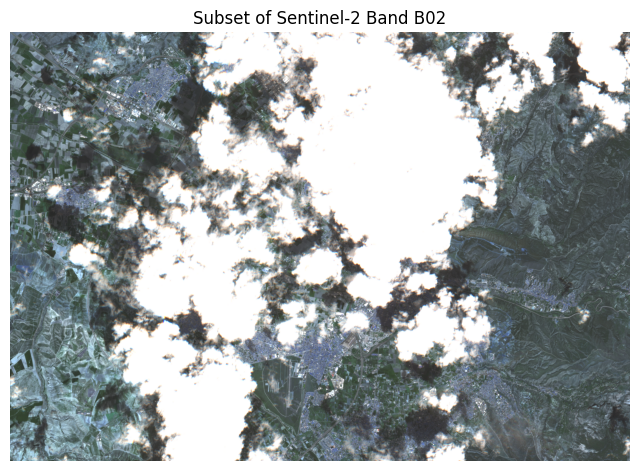

In [218]:
rgb = np.clip(stacked_data[:3, ...].transpose(1, 2, 0), 0, 5500) / 5500
plt.figure(figsize=(8, 8))
plt.imshow(rgb)  # Use 'viridis' or other colormaps for variety
# plt.colorbar(label='Pixel Value')
plt.title("Subset of Sentinel-2 Band B02")
plt.axis('off')
plt.show()